Original code: 
https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

In [1]:
# !pip uninstall torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install matplotlib

In [2]:
# import torch
# torch.cuda.empty_cache()

In [7]:
epochs=7

In [18]:
import gc
import torch

# Clear CUDA cache function
def clear_cuda_cache():
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    gc.collect()

clear_cuda_cache()

c:\Users\hp\Desktop\context_detector\env\lib\site-packages\torch\cuda\memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
c:\Users\hp\Desktop\context_detector\env\lib\site-packages\torch\cuda\memory.py:356: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


2.3.1+cu118
11.8
8700
True
Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_23284\3591758718.py:39: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


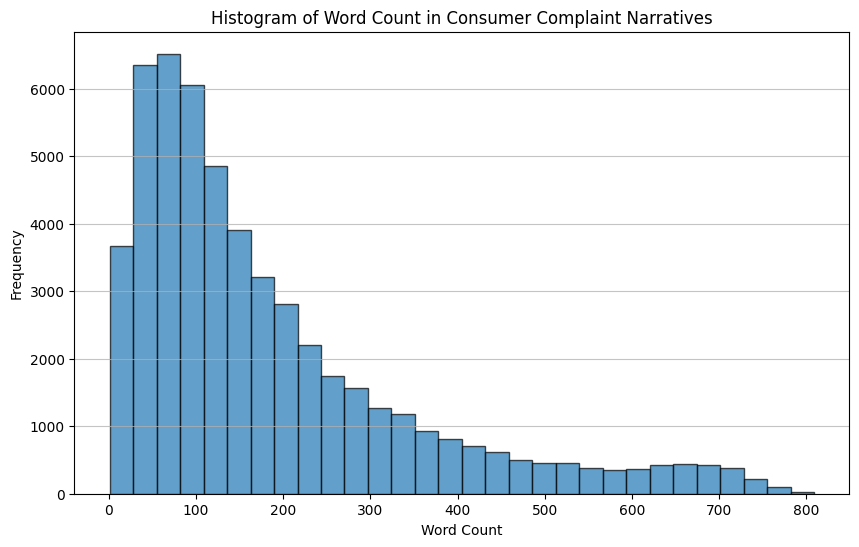

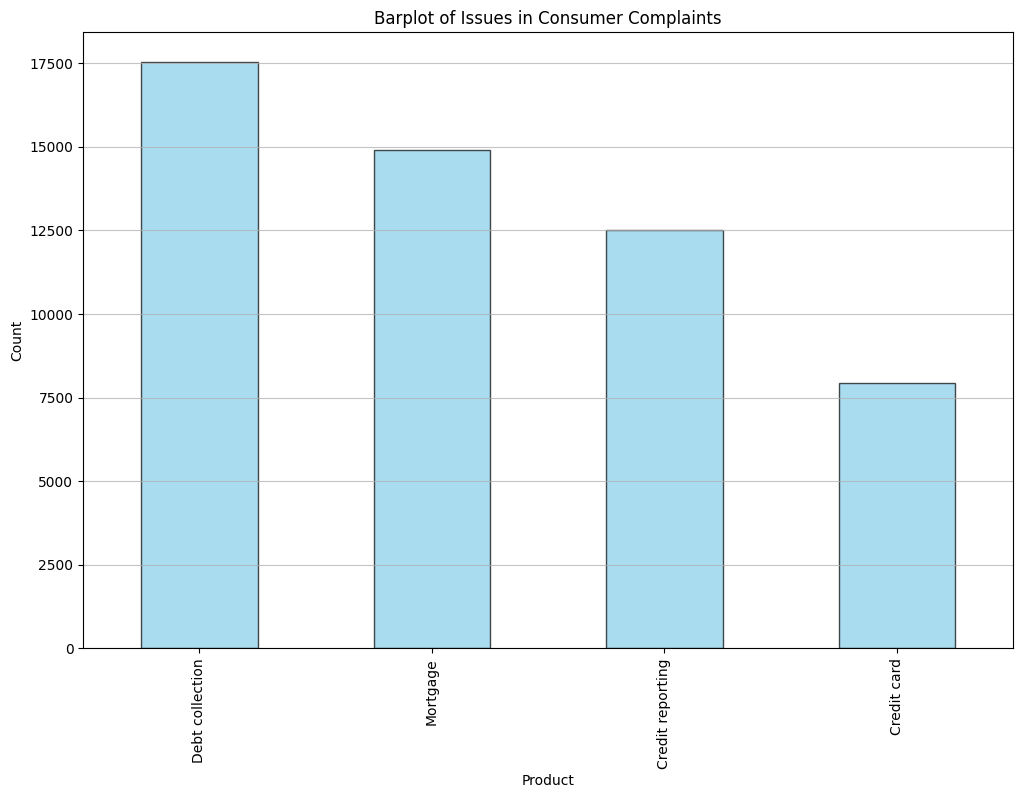

Loading tokenizer


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Extracting tokens...
Load model...


You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.10.intermediate.dense.bias', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.6.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.self.value.bias', 'bert.encoder.layer.2.output.dense.weight', 'cls.pre

In [13]:
import os
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw
import nltk

# Check torch and CUDA versions
print(torch.__version__)  # Should display the version of PyTorch with CUDA support
print(torch.version.cuda)  # Should display the CUDA version
print(torch.backends.cudnn.version())  # Should display the cuDNN version
print(torch.cuda.is_available())  # Should return True if CUDA is available


# Set global variables and tokenizer parameters
SUBSAMPLE = False
SEED = 42
LR = 2e-5
PLOT_EDA = False
batch_size = 10
epochs = 7

tokenizer_params = {
    'add_special_tokens': True,     # adds [CLS] and [SEP] tags
    'return_attention_mask': True,  # useful for distinguishing between actual data and padding
    'pad_to_max_length': True,      # to ensure all sequences have the same length
    'truncation': True,
    'max_length': 128,  #256             # set the maximum length for sequences
    'return_tensors': 'pt'          # use 'pt' when using PyTorch, 'tf' for TensorFlow
}

# Load data 
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']]

### PREPROCESSING
# Drop rows with all columns missing and underrepresented categories
data = data.dropna()
categories_to_drop = ['Consumer Loan', 
                    'Bank account or service',
                    'Student loan', 
                    'Prepaid card',
                    'Payday loan', 
                    'Money transfers', 
                    'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]

# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.25, random_state=SEED)

if PLOT_EDA: 
    # EDA plots
    # 1. Create a histogram with the word count for the column 'consumer_complaint_narrative'
    data['narrative_word_count'] = data['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    plt.hist(data['narrative_word_count'], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Word Count in Consumer Complaint Narratives')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # 2. Create a barplot counting each unique value in the column 'issue'
    issue_counts = data['product'].value_counts()

    plt.figure(figsize=(12, 8))
    issue_counts.plot(kind='bar', color='skyblue', edgecolor='k', alpha=0.7)
    plt.title('Barplot of Issues in Consumer Complaints')
    plt.xlabel('Product')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Encoding labels
labels_ = data['product'].unique()
label_dict = {}
for idx, labels_ in enumerate(labels_):
    label_dict[labels_] = idx

# Encode product labels
data['label'] = data['product'].replace(label_dict)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    data.index.values,
    data['label'].values,
    test_size = 0.2,
    random_state=SEED,
    stratify = data['label'])

# Define data type in the original dataset
data['data_type'] = ['not_set'] * data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

print('Loading tokenizer')
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased',   # model name
                                          do_lower_case=True)    # convert to lowercase

encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

print('Extracting tokens...')
# Extract token input IDs and attention masks
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

# Convert labels into tensors
labels_train = torch.tensor(data[data.data_type=='train']['label'].values)

# Repeat process for validation data
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val']['label'].values)

# Create tensor 
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

print("Load model...")
# lOAD PRE-TRAINED MODEL 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

# AdamW for Adam optimization with Weight decay
optimizer = AdamW(model.parameters(),
                  lr=LR,   
                  eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=100,
                                            num_training_steps=len(dataloader_train)*epochs)


In [10]:
# Define accuracy functions
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [14]:
### CREATE BENCHMARK USING A ZERO-SHOT MODEL 
def evaluate(model, dataloader):
    model.eval()
    preds, true_vals = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        preds.append(outputs.logits.detach().cpu().numpy())
        true_vals.append(inputs['labels'].detach().cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return preds, true_vals

# Load the model and data on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initial evaluation on validation set
initial_preds, initial_true_vals = evaluate(model, dataloader_validation)
initial_f1_score = f1_score_func(initial_preds, initial_true_vals)
print(f'F1 Score: {initial_f1_score}')
accuracy_per_class(initial_preds, initial_true_vals)


initial_preds, initial_true_vals = evaluate(model, dataloader_validation)
initial_accuracy = accuracy_func(initial_preds, initial_true_vals)
print(f'Initial Accuracy (Before Fine-tuning): {initial_accuracy}')

F1 Score: 0.09053166635322869
Class: Debt collection
Accuracy: 0/3511

Class: Mortgage
Accuracy: 0/2984

Class: Credit card
Accuracy: 0/1586

Class: Credit reporting
Accuracy: 2504/2505

Initial Accuracy (Before Fine-tuning): 0.23653882486302663


Starting model training...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [05:15<?, ?it/s]


Epoch 1
Training loss: 0.7827475736464036


 10%|█         | 1/10 [05:37<50:39, 337.71s/it]

Validation loss: 0.4809841920212923
F1 Score (Weighted): 0.8430442725699462
Accuracy: 0.84246316584813


 10%|█         | 1/10 [10:57<50:39, 337.71s/it]


Epoch 2
Training loss: 0.42613115408674035


 20%|██        | 2/10 [11:19<45:22, 340.37s/it]

Validation loss: 0.461401443532352
F1 Score (Weighted): 0.8424735405167835
Accuracy: 0.8469965999244428


 20%|██        | 2/10 [16:39<45:22, 340.37s/it]


Epoch 3
Training loss: 0.35222134160432683


 30%|███       | 3/10 [17:02<39:49, 341.38s/it]

Validation loss: 0.374484573663697
F1 Score (Weighted): 0.8799997453065075
Accuracy: 0.8802417831507366


 30%|███       | 3/10 [22:22<39:49, 341.38s/it]


Epoch 4
Training loss: 0.2866250513119376


 40%|████      | 4/10 [22:45<34:11, 341.87s/it]

Validation loss: 0.44258056728936296
F1 Score (Weighted): 0.8823580340503772
Accuracy: 0.8821307140158671


 40%|████      | 4/10 [28:04<34:11, 341.87s/it]


Epoch 5
Training loss: 0.24579903007182266


 50%|█████     | 5/10 [28:27<28:29, 341.89s/it]

Validation loss: 0.5263759177578486
F1 Score (Weighted): 0.8738820465848681
Accuracy: 0.8738194182092935


 50%|█████     | 5/10 [33:44<28:29, 341.89s/it]


Epoch 6
Training loss: 0.2075879846299795


 60%|██████    | 6/10 [34:06<22:43, 340.99s/it]

Validation loss: 0.5014837485447323
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


 60%|██████    | 6/10 [39:23<22:43, 340.99s/it]


Epoch 7
Training loss: 0.17769113465767072


 70%|███████   | 7/10 [39:45<17:01, 340.50s/it]

Validation loss: 0.519236488890417
F1 Score (Weighted): 0.8817105363922219
Accuracy: 0.8813751416698149


 70%|███████   | 7/10 [45:00<17:01, 340.50s/it]


Epoch 8
Training loss: 0.1527449153289874


 80%|████████  | 8/10 [45:22<11:18, 339.43s/it]

Validation loss: 0.5667632109389695
F1 Score (Weighted): 0.8860623712049127
Accuracy: 0.8859085757461277


 80%|████████  | 8/10 [50:38<11:18, 339.43s/it]


Epoch 9
Training loss: 0.1332386493833687


 90%|█████████ | 9/10 [51:00<05:38, 338.89s/it]

Validation loss: 0.609079635480305
F1 Score (Weighted): 0.8876796336385793
Accuracy: 0.887797506611258


 90%|█████████ | 9/10 [56:16<05:38, 338.89s/it]


Epoch 10
Training loss: 0.10703241500867972


100%|██████████| 10/10 [56:39<00:00, 339.91s/it]


Validation loss: 0.6031850886349966
F1 Score (Weighted): 0.8919741846444197
Accuracy: 0.8919531545145448


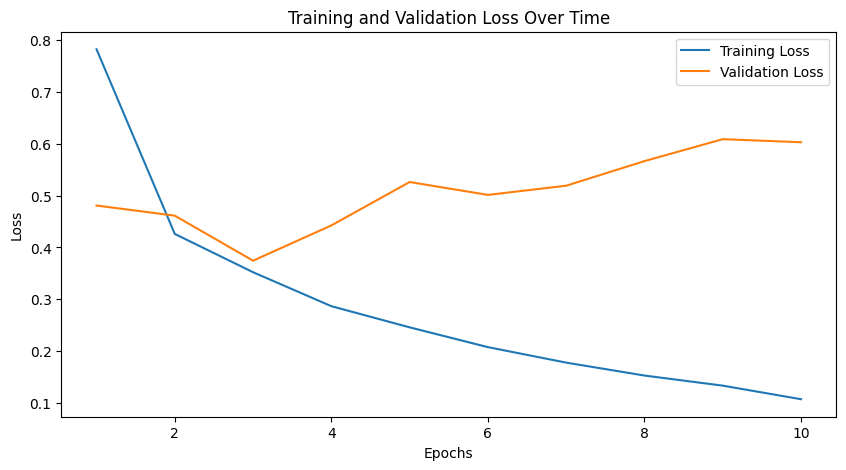

In [6]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Starting model training...")
# Move model to device
model.to(device)

def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Ensure the directory for saving models exists
os.makedirs('models', exist_ok=True)

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model at each epoch 
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_accuracy = accuracy_func(predictions, true_vals)
    validation_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_accuracy}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [6]:
model = DistilBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict))

model.to(device)

# Load best model and make prediction
model.load_state_dict(torch.load('models/finetuned_BERT_epoch_6.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Debt collection
Accuracy: 269/277

Class: Payday loan
Accuracy: 9/12

Class: Student loan
Accuracy: 2/8



In [7]:
# Check the model using one sample


### Fine-tunning with data augmentation 

Data augmentation techniques: 
1. Synonym replacement 
2. Random insertion 
3. Random swap 
4. Random deletion 
5. Back translation 
6. Noise injection 


Use data augmentation during model training. 

In [8]:
# !pip install nlpaug
# !pip install nltk
# !python -m nltk.downloader all
# !pip install wordnet

In [5]:
import nlpaug.augmenter.word as naw
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

aug_syn = naw.SynonymAug(aug_src='wordnet')
# aug_insert = naw.RandomWordAug(action="insert")
aug_swap = naw.RandomWordAug(action="swap")
aug_delete = naw.RandomWordAug(action="delete")
augmenters = [aug_syn, aug_swap, aug_delete]

# Apply data augmentation to data 
def augment_text(text, augmenters, num_augmentations=1):
    augmented_texts = [text]
    for _ in range(num_augmentations):
        augmenter = random.choice(augmenters)
        augmented_text = augmenter.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [24]:
augmented_data = []
for index, row in data.iterrows():
    text = row['consumer_complaint_narrative']
    augmented_texts = augment_text(text, augmenters, num_augmentations=2)
    for augmented_text in augmented_texts:
        augmented_data.append((augmented_text, row['label']))

# Create new dataframe with augmented data and combine it with original dataset
augmented_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'label'])
data = pd.concat([data, augmented_df], ignore_index=True)

# Continue with tokenization and creating DataLoader as before
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train']['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val']['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\3267950575.py:25: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


       date_received          product                            sub_product  \
191335    03/19/2015  Debt collection  Other (i.e. phone, health club, etc.)   
191417    03/26/2015  Debt collection  Other (i.e. phone, health club, etc.)   
191636    03/19/2015  Debt collection                          I do not know   
191858    03/19/2015  Debt collection                          I do not know   
192023    03/19/2015  Debt collection                            Credit card   

                                        issue  \
191335  Cont'd attempts collect debt not owed   
191417  Cont'd attempts collect debt not owed   
191636  Cont'd attempts collect debt not owed   
191858  Cont'd attempts collect debt not owed   
192023    Improper contact or sharing of info   

                                  sub_issue  \
191335    Debt resulted from identity theft   
191417                     Debt is not mine   
191636                     Debt is not mine   
191858                     Debt is n

c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ValueError: not enough values to unpack (expected 2, got 1)

: 

### Run model on augmented data

Starting model training...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [01:05<?, ?it/s]


Epoch 1
Training loss: 0.006082784717272252


 10%|█         | 1/10 [01:10<10:36, 70.75s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 10%|█         | 1/10 [02:16<10:36, 70.75s/it]


Epoch 2
Training loss: 0.006608077742375734


 20%|██        | 2/10 [02:21<09:26, 70.83s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 20%|██        | 2/10 [03:27<09:26, 70.83s/it]


Epoch 3
Training loss: 0.00646316605582457


 30%|███       | 3/10 [03:32<08:16, 70.94s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 30%|███       | 3/10 [04:38<08:16, 70.94s/it]


Epoch 4
Training loss: 0.006043347191404213


 40%|████      | 4/10 [04:43<07:05, 70.96s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 40%|████      | 4/10 [05:49<07:05, 70.96s/it]


Epoch 5
Training loss: 0.006726095678091915


 50%|█████     | 5/10 [05:54<05:54, 70.99s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 50%|█████     | 5/10 [07:00<05:54, 70.99s/it]


Epoch 6
Training loss: 0.00625130129893395


 60%|██████    | 6/10 [07:05<04:43, 70.88s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 60%|██████    | 6/10 [2:33:13<04:43, 70.88s/it]


Epoch 7
Training loss: 0.007441130374450086


 70%|███████   | 7/10 [2:33:18<2:25:47, 2915.70s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 70%|███████   | 7/10 [2:34:21<2:25:47, 2915.70s/it]


Epoch 8
Training loss: 0.007166428544389253


 80%|████████  | 8/10 [2:34:26<1:06:58, 2009.24s/it]

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 80%|████████  | 8/10 [2:35:33<1:06:58, 2009.24s/it]


Epoch 9
Training loss: 0.006366081038405272


 90%|█████████ | 9/10 [2:35:38<23:23, 1403.57s/it]  

Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


 90%|█████████ | 9/10 [2:36:45<23:23, 1403.57s/it]


Epoch 10
Training loss: 0.006900036631674139


100%|██████████| 10/10 [2:36:50<00:00, 941.05s/it]


Validation loss: 0.2231310906331055
F1 Score (Weighted): 0.9419937774368152
Accuracy: 0.9427609427609428


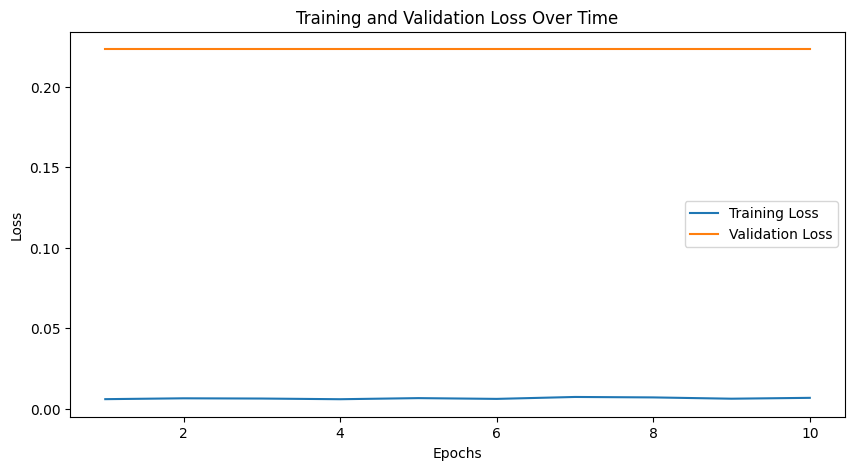

In [10]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Starting model training...")
# Move model to device
model.to(device)


# Evaluation function
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model at each epoch 
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_aug_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_accuracy = accuracy_func(predictions, true_vals)
    validation_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_accuracy}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [13]:
import os

### PERSONAL CODE 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Starting model training...")
# Move model to device
model.to(device)

# Load data
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data.dropna()
categories_to_drop = ['Consumer Loan', 'Student loan', 'Prepaid card',
                    'Payday loan', 'Money transfers', 'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]
data = data[['product', 'consumer_complaint_narrative']]
data['label'] = data['product'].replace(label_dict)

# Split data into training and validation sets
train_data = data.sample(frac=0.8, random_state=SEED)
val_data = data.drop(train_data.index)

# Check class distribution (we will use data augmentation to oversample underrepresented classes)
class_counts = data['product'].value_counts()
print(class_counts)

# Determine the maximum class count
max_count = class_counts.max()

# Augment minority classes to balance the dataset
augmented_data = []
for product, count in class_counts.items():
    if count < max_count:
        subset = data[data['product'] == product]
        needed_samples = max_count - count
        while needed_samples > 0:
            for index, row in subset.iterrows():
                if needed_samples <= 0:
                    break
                text = row['consumer_complaint_narrative']
                augmented_texts = augment_text(text, augmenters, num_augmentations=1)
                for augmented_text in augmented_texts:
                    augmented_data.append((augmented_text, row['label']))
                    needed_samples -= 1

# Create new dataframe with augmented data and combine it with the training dataset
augmented_df = pd.DataFrame(augmented_data, columns=['product', 'label'])
train_data = pd.concat([train_data, augmented_df], ignore_index=True)

# Tokenize and encode the datasets
encoded_data_train = tokenizer.batch_encode_plus(
    train_data['product'].values,
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_data['product'].values,
    **tokenizer_params
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_data['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=32)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=32)


# Define evaluation function 
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Ensure the directory for saving models exists
os.makedirs('models', exist_ok=True)

# Training loop
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model at each epoch 
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_aug_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_accuracy = accuracy_func(predictions, true_vals)
    validation_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_accuracy}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

Starting model training...
Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_17120\2419771722.py:17: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


product
Debt collection    1385
Name: count, dtype: int64


c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [25]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Download necessary NLTK resources
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Define augmenters
aug_syn = naw.SynonymAug(aug_src='wordnet')
aug_swap = naw.RandomWordAug(action="swap")
aug_delete = naw.RandomWordAug(action="delete")
augmenters = [aug_syn, aug_swap, aug_delete]

# Function to apply data augmentation to text
def augment_text(text, augmenters, num_augmentations=1):
    augmented_texts = [text]
    for _ in range(num_augmentations):
        augmenter = random.choice(augmenters)
        augmented_text = augmenter.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Load data
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']]
data = data.dropna()
categories_to_drop = ['Consumer Loan', 'Student loan', 'Prepaid card', 'Payday loan', 'Money transfers', 'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]


# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.25, random_state=SEED)

# Example label dictionary for demonstration
label_dict = {label: idx for idx, label in enumerate(data['product'].unique())}

# Prepare data
data['label'] = data['product'].replace(label_dict)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    data.index.values,
    data['label'].values,
    test_size = 0.2,
    random_state=SEED,
    stratify = data['label'])

# Define data type in the original dataset
data['data_type'] = ['not_set'] * data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

# Determine maximum class count 
max_count = data['product'].value_counts().max()

# Augment minority classes to balance the dataset
augmented_data = []
for product, count in class_counts.items():
    if count < max_count:
        subset = data[data['product'] == product]
        needed_samples = max_count - count
        while needed_samples > 0:
            for index, row in subset.iterrows():
                if needed_samples <= 0:
                    break
                text = row['consumer_complaint_narrative']
                augmented_texts = augment_text(text, augmenters, num_augmentations=1)
                for augmented_text in augmented_texts:
                    augmented_data.append((augmented_text, row['label']))
                    needed_samples -= 1

# Create new dataframe with augmented data and combine it with the training dataset
augmented_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'label'])
train_data = pd.concat([train_data, augmented_df], ignore_index=True)

print(train_data.head())



#! # Ensure labels are integers (NOT NECESSARY?)
# train_data['label'] = train_data['label'].astype(int)
# val_data['label'] = val_data['label'].astype(int)

# Tokenize and encode the datasets
encoded_data_train = tokenizer.batch_encode_plus(
    train_data['consumer_complaint_narrative'].values,
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_data['consumer_complaint_narrative'].values,
    **tokenizer_params
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data['label'].values, dtype=torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_data['label'].values, dtype=torch.long)

# dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
# dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=32)
# dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=32)

# # Load device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the model with dropout
# class DistilBertForSequenceClassificationWithDropout(torch.nn.Module):
#     def __init__(self, model_name, num_labels, dropout_rate=0.3):
#         super(DistilBertForSequenceClassificationWithDropout, self).__init__()
#         self.distilbert = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
#         self.dropout = torch.nn.Dropout(dropout_rate)
#         self.classifier = torch.nn.Linear(self.distilbert.config.hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask, labels=None):
#         # Get the outputs from the DistilBERT model
#         outputs = self.distilbert.distilbert(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_state = outputs[0]  # (batch_size, seq_len, hidden_size)

#         # Apply dropout to the first token (CLS token) in the hidden state
#         pooled_output = hidden_state[:, 0]  # (batch_size, hidden_size)
#         pooled_output = self.dropout(pooled_output)

#         # Pass the pooled output through the classifier layer
#         logits = self.classifier(pooled_output)

#         # Calculate the loss if labels are provided
#         loss = None
#         if labels is not None:
#             loss_fct = torch.nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))


#         return (loss, logits)

# model = DistilBertForSequenceClassificationWithDropout(model_name="distilbert-base-uncased", num_labels=len(label_dict))

# # model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
# #                                                       num_labels=len(label_dict),
# #                                                       output_attentions=False,
# #                                                       output_hidden_states=False)


# model.to(device)

# # AdamW for Adam optimization with Weight decay
# optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8, weight_decay=0.01)  # Added weight_decay for L2 regularization

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(dataloader_train) * epochs)

# # Define evaluation function
# def evaluate(dataloader_val):
#     model.eval()
#     loss_val_total = 0
#     predictions, true_vals = [], []

#     for batch in dataloader_val:
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {
#             'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'labels': batch[2],
#         }

#         with torch.no_grad():
#             outputs = model(**inputs)
#         loss = outputs.loss  
#         logits = outputs.logits  
#         loss_val_total += loss.item()
#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.append(logits)
#         true_vals.append(label_ids)

#     loss_val_avg = loss_val_total / len(dataloader_val)
#     predictions = np.concatenate(predictions, axis=0)
#     true_vals = np.concatenate(true_vals, axis=0)

#     return loss_val_avg, predictions, true_vals

# # Initialize lists to store losses for plotting
# training_losses = []
# validation_losses = []

# # Ensure the directory for saving models exists
# os.makedirs('models', exist_ok=True)

# print("Starting training...")
# # Training loop
# for epoch in tqdm(range(1, epochs+1)):
#     model.train()
#     loss_train_total = 0
#     progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
#     for batch in progress_bar:
#         model.zero_grad()
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {
#             'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'labels': batch[2],
#         }
#         outputs = model(**inputs)
#         loss = outputs.loss  # Changed from outputs[0] to outputs.loss
#         logits = outputs.logits  # Changed from outputs[1] to outputs.logits
#         loss_train_total += loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

#     # Save the model at each epoch 
#     torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_aug_{epoch}.model')

#     tqdm.write(f'\nEpoch {epoch}')
#     loss_train_avg = loss_train_total / len(dataloader_train)
#     training_losses.append(loss_train_avg)
#     tqdm.write(f'Training loss: {loss_train_avg}')

#     val_loss, predictions, true_vals = evaluate(dataloader_validation)
#     val_f1 = f1_score_func(predictions, true_vals)
#     val_accuracy = accuracy_func(predictions, true_vals)
#     validation_losses.append(val_loss)
#     tqdm.write(f'Validation loss: {val_loss}')
#     tqdm.write(f'F1 Score (Weighted): {val_f1}')
#     tqdm.write(f'Accuracy: {val_accuracy}')

# # Plotting the training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
# plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Time')
# plt.legend()
# plt.show()


Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_23284\6877201.py:25: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')


            product                       consumer_complaint_narrative  label
0   Debt collection  I went on the Internet to find this debt colle...      0
1  Credit reporting  The XXXX credit bureaus are not reporting XXXX...      3
2  Credit reporting  I purchased a XXXX years ago. I paid on time. ...      3
3          Mortgage  in 2012 I applied for a loan modification with...      1
4   Debt collection  I rented a home, and subsequent to my move out...      0
